# Capstone - Brain tumour classification


### Problem statement
Typically to classify a brain tumour, radiologists and neurologists would go manually through MRI scans to locate the tumour and extract information; they would then conclude on the tumour type by performing a biopsy. However going through over a hundred images per patient can be a tedious and time-consuming process.  
Could we accelerate this process by pre-classifying brain tumours based on their MRI scans before a radiologist starts looking at them?  
  
### Dataset
Based on the VASARI brain tumours dataset, we will aim at building a classifier that can differentiate Astrocytomas, Glioblastomas (GBM) and Oligodendrogliomas based on their MRI scans.  
The VASARI dataset contains three different sets of materials:
 - A CSV file containing the diagnosis and survival time of 127 patients
 - MRI scans for these 127 patients
 - A CSV file containing 30 tumour features extracted manually by three neuroradiologists from the MRI scans of 32 patients (glioblastoma, n = 20; oligodendroglioma, n = 7; astrocytoma, n = 5), such as side of tumour epicenter, enhancement quality, enhancing tumour, necrotic tumour, size, etc.
   
### Process
 1. We will first try to build a classifer based on the features manually extracted manually by radiologists. Therefore this notebook will focus mainly on exploring the two CSV files.  
 2. We will then try to extract these features from the MRI scans and make sure that they match those from the CSV file. According to the litterature on brain tumour classfication, this step will require: 
     - Selecting the relevant images to be analysed (out of over 100 per patient)
     - Filtering them to remove the noise inherent to all MR images
     - Segmenting the image to isolate the tumour
     - Extracting relevant features - based on our first model's performance, we might want to add some additional features on top of the VASARI features to improve our model (some papers in particular refer to tumour concavity and texture)
 3. Finally we will classify the remaining 95 patients.
   
### Goal and success criteria
Our goal is to build a classifier that performs better than the baseline. We would like to predict probabilities of each tumour type in order to assist radiologists in their diagnosis. We will compare several models (such as Logistic Regression, Naive Bayes and Random Forests) based on their accuracy and ROC curves and select the most relevant one. We will also try to trim the number of features to improve our model.

References for the VASARI dataset:
 - Scarpace, Lisa, Flanders, Adam E., Jain, Rajan, Mikkelsen, Tom, & Andrews, David W. (2015). Data From REMBRANDT. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.588OZUZB  
 - Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057.

1. [Getting the data](#Part1)  
    a. [First CSV file - Tumour features](#Part1a)  
    b. [Second CSV file - Diagnosis](#Part1b)  
    c. [Add patient diagnosis to features dataframe](#Part1c)  
2. [Cleaning the data](#Part2)  
3. [Exploring the data](#Part3)  
4. [Studying feature importance with PCA](#Part4)  
5. [Building and training models on manually extracted features](#Part5)  
    a. [Logistic Regression](#Part5a)  
    b. [KNN](#Part5b)  
    c. [Random Forest](#Part5c)  
    d. [LDA](#Part5d)  
    e. [Naive Bayes](#Part5e)  
    f. [Compare model scores](#Part5f)   
6. [Feature Selection](#Part6)  
    a. [SelectKBest](#Part6a)  
    b. [RFE](#Part6b)   
    c. [Compare model scores](#Part6c)
7. [Extraction of MRI Scans](#Part7)  
    a. [Reshape images](#Part7a)  
    b. [Remove noise](#Part7b)  
    c. [Multimodal segmentation from T2 and FLAIR images](#Part7c)  
    d. [Extract features](#Part7d)  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
pd.set_option("display.max_columns",101)

<a id='Part1'></a>

## 1. Getting the data

<a id='Part1a'></a>

### a. First CSV file - Tumour features

In [2]:
tumour_features = pd.read_excel('VASARI_MRI_features (gmdi - wiki).xls')
tumour_features.head()

,GMDI,ID,radiologist,comments,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,900_00_1961,90,Radiologist #1,well defined insular tumor,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,101,Radiologist #2,NaN,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,81,Radiologist #3,NaN,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5299,176,Radiologist #1,"two components seem to be enhancing and edema,...",2,1,1,3,4,3,4,1,1,2,4,2,2,5,2,1,1,2,1,2,1,2,2,1,1,7,2,3,10,9
4,900_00_5299,161,Radiologist #2,NaN,2,1,1,3,4,3,4,1,2,1,4,2,3,5,2,2,1,2,1,2,1,2,2,2,2,8,2,2,11,8


In [3]:
# Rename columns with meaningful names and drop ID and comments columns

cols = ['Sample','Radiologist','Tumor_Location','Side_of_Tumor_Epicenter','Eloquent_Brain','Enhancement_Quality',
        'Proportion_Enhancing','Proportion_nCET', 'Proportion_Necrosis','Cyst','Multifocal_or_Multicentric',
        'T1_FLAIR_Ratio','Thickness_Enhancing_Margin','Definition_Enhancing_Margin', 'Definition_Non_Enhancing_Margin',
        'Proportion_of_Edema','Edema_Crosses_Midline','Hemorrhage','Diffusion','Pial_Invasion','Ependymal_Invasion',
        'Cortical_Involvement','Deep_WM_Invasion','nCET_Tumor_Crosses_Midline','Enhancing_Tumor_Crosses_Midline',
        'Satellites','Calvarial_Remodeling','Extent_Resection_Enhancing_Tumor','Extent_Resection_nCET',
        'Extent_Resection_Vasogenic_Edema','Lesion_Size_x','Lesion_Size_y']

tumour_features = tumour_features.drop(['ID','comments'], axis=1)
tumour_features.columns = cols
tumour_features.head()

,Sample,Radiologist,Tumor_Location,Side_of_Tumor_Epicenter,Eloquent_Brain,Enhancement_Quality,Proportion_Enhancing,Proportion_nCET,Proportion_Necrosis,Cyst,Multifocal_or_Multicentric,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Proportion_of_Edema,Edema_Crosses_Midline,Hemorrhage,Diffusion,Pial_Invasion,Ependymal_Invasion,Cortical_Involvement,Deep_WM_Invasion,nCET_Tumor_Crosses_Midline,Enhancing_Tumor_Crosses_Midline,Satellites,Calvarial_Remodeling,Extent_Resection_Enhancing_Tumor,Extent_Resection_nCET,Extent_Resection_Vasogenic_Edema,Lesion_Size_x,Lesion_Size_y
0,900_00_1961,Radiologist #1,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,Radiologist #2,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,Radiologist #3,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5299,Radiologist #1,2,1,1,3,4,3,4,1,1,2,4,2,2,5,2,1,1,2,1,2,1,2,2,1,1,7,2,3,10,9
4,900_00_5299,Radiologist #2,2,1,1,3,4,3,4,1,2,1,4,2,3,5,2,2,1,2,1,2,1,2,2,2,2,8,2,2,11,8


<a id='Part1b'></a>

### b. Second CSV file - Diagnosis

In [4]:
# Read in CSV and format dataframe

patients_info = pd.read_excel('clinical_2014-01-16.xlsx')
patients_info.drop(patients_info.columns[6:], axis=1, inplace=True)
patients_info.columns = ['Sample','Age','Gender','Survival_months','Disease','Grade']
patients_info.head()

,Sample,Age,Gender,Survival_months,Disease,Grade
0,900_00_1961,--,--,15,ASTROCYTOMA,II
1,900_00_5332,--,--,15,GBM,--
2,900_00_5308,--,--,17,ASTROCYTOMA,III
3,900_00_5316,--,--,17,GBM,--
4,900_00_5317,--,--,17,GBM,--


<a id='Part1c'></a>

### c. Add patient diagnosis to features dataframe

In [5]:
# Merge the two dataframes
tumours = pd.merge(patients_info[['Sample','Disease','Survival_months']], tumour_features, on='Sample', how='inner')

<a id='Part2'></a>

## 2. Cleaning the data

In [6]:
# Assign survival column type to int
tumours['Survival_months'] = tumours['Survival_months'].astype('int')

In [7]:
# Display first index of each disease

print 'Astocytoma first index:', tumours.loc[tumours['Disease']==' ASTROCYTOMA', 'Disease'].index[0]
print 'GBM first index:', tumours.loc[tumours['Disease']==' GBM', 'Disease'].index[0]
print 'Oligodendroglioma first index:', tumours.loc[tumours['Disease']==' OLIGODENDROGLIOMA', 'Disease'].index[0]

Astocytoma first index: 0
GBM first index: 3
Oligodendroglioma first index: 21


In [8]:
# Encode Disease column
from sklearn.preprocessing import LabelEncoder

tumours['Disease'] = LabelEncoder().fit_transform(tumours['Disease'])

tumours.head()

,Sample,Disease,Survival_months,Radiologist,Tumor_Location,Side_of_Tumor_Epicenter,Eloquent_Brain,Enhancement_Quality,Proportion_Enhancing,Proportion_nCET,Proportion_Necrosis,Cyst,Multifocal_or_Multicentric,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Proportion_of_Edema,Edema_Crosses_Midline,Hemorrhage,Diffusion,Pial_Invasion,Ependymal_Invasion,Cortical_Involvement,Deep_WM_Invasion,nCET_Tumor_Crosses_Midline,Enhancing_Tumor_Crosses_Midline,Satellites,Calvarial_Remodeling,Extent_Resection_Enhancing_Tumor,Extent_Resection_nCET,Extent_Resection_Vasogenic_Edema,Lesion_Size_x,Lesion_Size_y
0,900_00_1961,0,15,Radiologist #1,"1, 2, 3",1,1,1,1,7,1,1,1,1,1,1,2,3,2,1,2,1,1,2,1,2,1,1,1,1,6,2,12,7
1,900_00_1961,0,15,Radiologist #2,"1, 3",1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,4,1,1,2,1,2,1,1,1,1,5,1,11,8
2,900_00_1961,0,15,Radiologist #3,3,1,1,1,1,8,1,1,1,1,1,1,2,2,1,1,2,1,1,2,1,2,1,1,1,1,4,1,11,7
3,900_00_5332,1,15,Radiologist #1,2,3,1,3,4,5,5,1,1,1,4,2,2,4,2,1,4,2,2,2,1,2,2,1,1,5,5,2,9,11
4,900_00_5332,1,15,Radiologist #2,2,3,3,3,5,4,5,1,1,2,4,2,2,3,2,2,3,2,2,2,1,2,2,1,1,6,2,2,13,11


In [9]:
# Display encoded numbers associated with each disease

print 'Astocytoma:', tumours.iloc[0, 1]
print 'GBM:', tumours.iloc[3, 1]
print 'Oligodendroglioma:', tumours.iloc[21, 1]

Astocytoma: 0
GBM: 1
Oligodendroglioma: 2


In [10]:
# Create a new dataframe with only one line per patient: 
# value is assigned to the most frequent score between the three radiologists 
# or if there are three different values to score from radiologist #2

dicty = {}
for col in tumours.columns[4:]:
    dicty[col]=[]
    for sample in tumours['Sample'].unique():
        count = tumours.loc[tumours['Sample']==sample, col].value_counts().sort_values(ascending=False)
        if len(count) == 2:
            dicty[col].append(count.index[0])
        else:
            dicty[col].append(tumours.loc[(tumours['Sample']==sample) & (tumours['Radiologist']=='Radiologist #2'), col].values[0])

In [11]:
target = tumours.iloc[range(0,96,3), 0:3].reset_index()            
tumours_clean = target.join(pd.DataFrame(dicty))
tumours_clean.drop(['index'], axis=1, inplace=True)
tumours_clean.head()

,Sample,Disease,Survival_months,Calvarial_Remodeling,Cortical_Involvement,Cyst,Deep_WM_Invasion,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Diffusion,Edema_Crosses_Midline,Eloquent_Brain,Enhancement_Quality,Enhancing_Tumor_Crosses_Midline,Ependymal_Invasion,Extent_Resection_Enhancing_Tumor,Extent_Resection_Vasogenic_Edema,Extent_Resection_nCET,Hemorrhage,Lesion_Size_x,Lesion_Size_y,Multifocal_or_Multicentric,Pial_Invasion,Proportion_Enhancing,Proportion_Necrosis,Proportion_nCET,Proportion_of_Edema,Satellites,Side_of_Tumor_Epicenter,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,Tumor_Location,nCET_Tumor_Crosses_Midline
0,900_00_1961,0,15,1,2,1,1,1,2,2,1,1,1,1,1,1,1,5,1,11,7,1,1,1,1,8,2,1,1,1,1,"1, 3",2
1,900_00_5332,1,15,1,2,1,1,2,2,4,2,3,3,2,2,5,2,5,2,13,11,1,2,4,5,5,4,1,3,2,4,2,2
2,900_00_5308,0,17,1,2,1,1,2,2,1,1,1,3,2,2,8,1,5,1,11,8,1,1,4,4,5,2,1,1,1,4,2,2
3,900_00_5316,1,17,1,2,1,1,2,2,1,2,1,3,2,1,7,2,1,1,14,9,1,1,4,4,5,4,1,3,2,4,4,2
4,900_00_5317,1,17,1,2,1,2,2,3,1,2,5,3,2,2,5,2,4,1,18,12,1,1,4,5,4,3,1,1,2,4,"1, 2, 3",2


<a id='Part3'></a>

## 3. Exploring the data

In [4]:
# Read clean csv file back in
tumours = pd.read_csv('tumours_target_features.csv', encoding='UTF8',index_col=0)

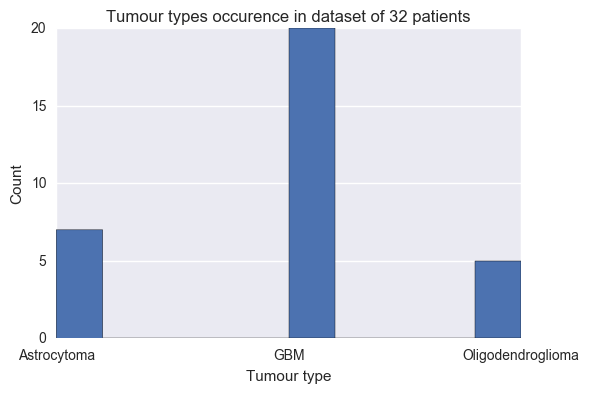

In [3]:
# Plot histogramme of tumour type in dataset (32 patients)

plt.hist(tumours['Disease'])
plt.xticks([0,1,2],['Astrocytoma', 'GBM', 'Oligodendroglioma'])
plt.xlabel('Tumour type')
plt.ylabel('Count')
plt.title('Tumour types occurence in dataset of 32 patients')
plt.show()

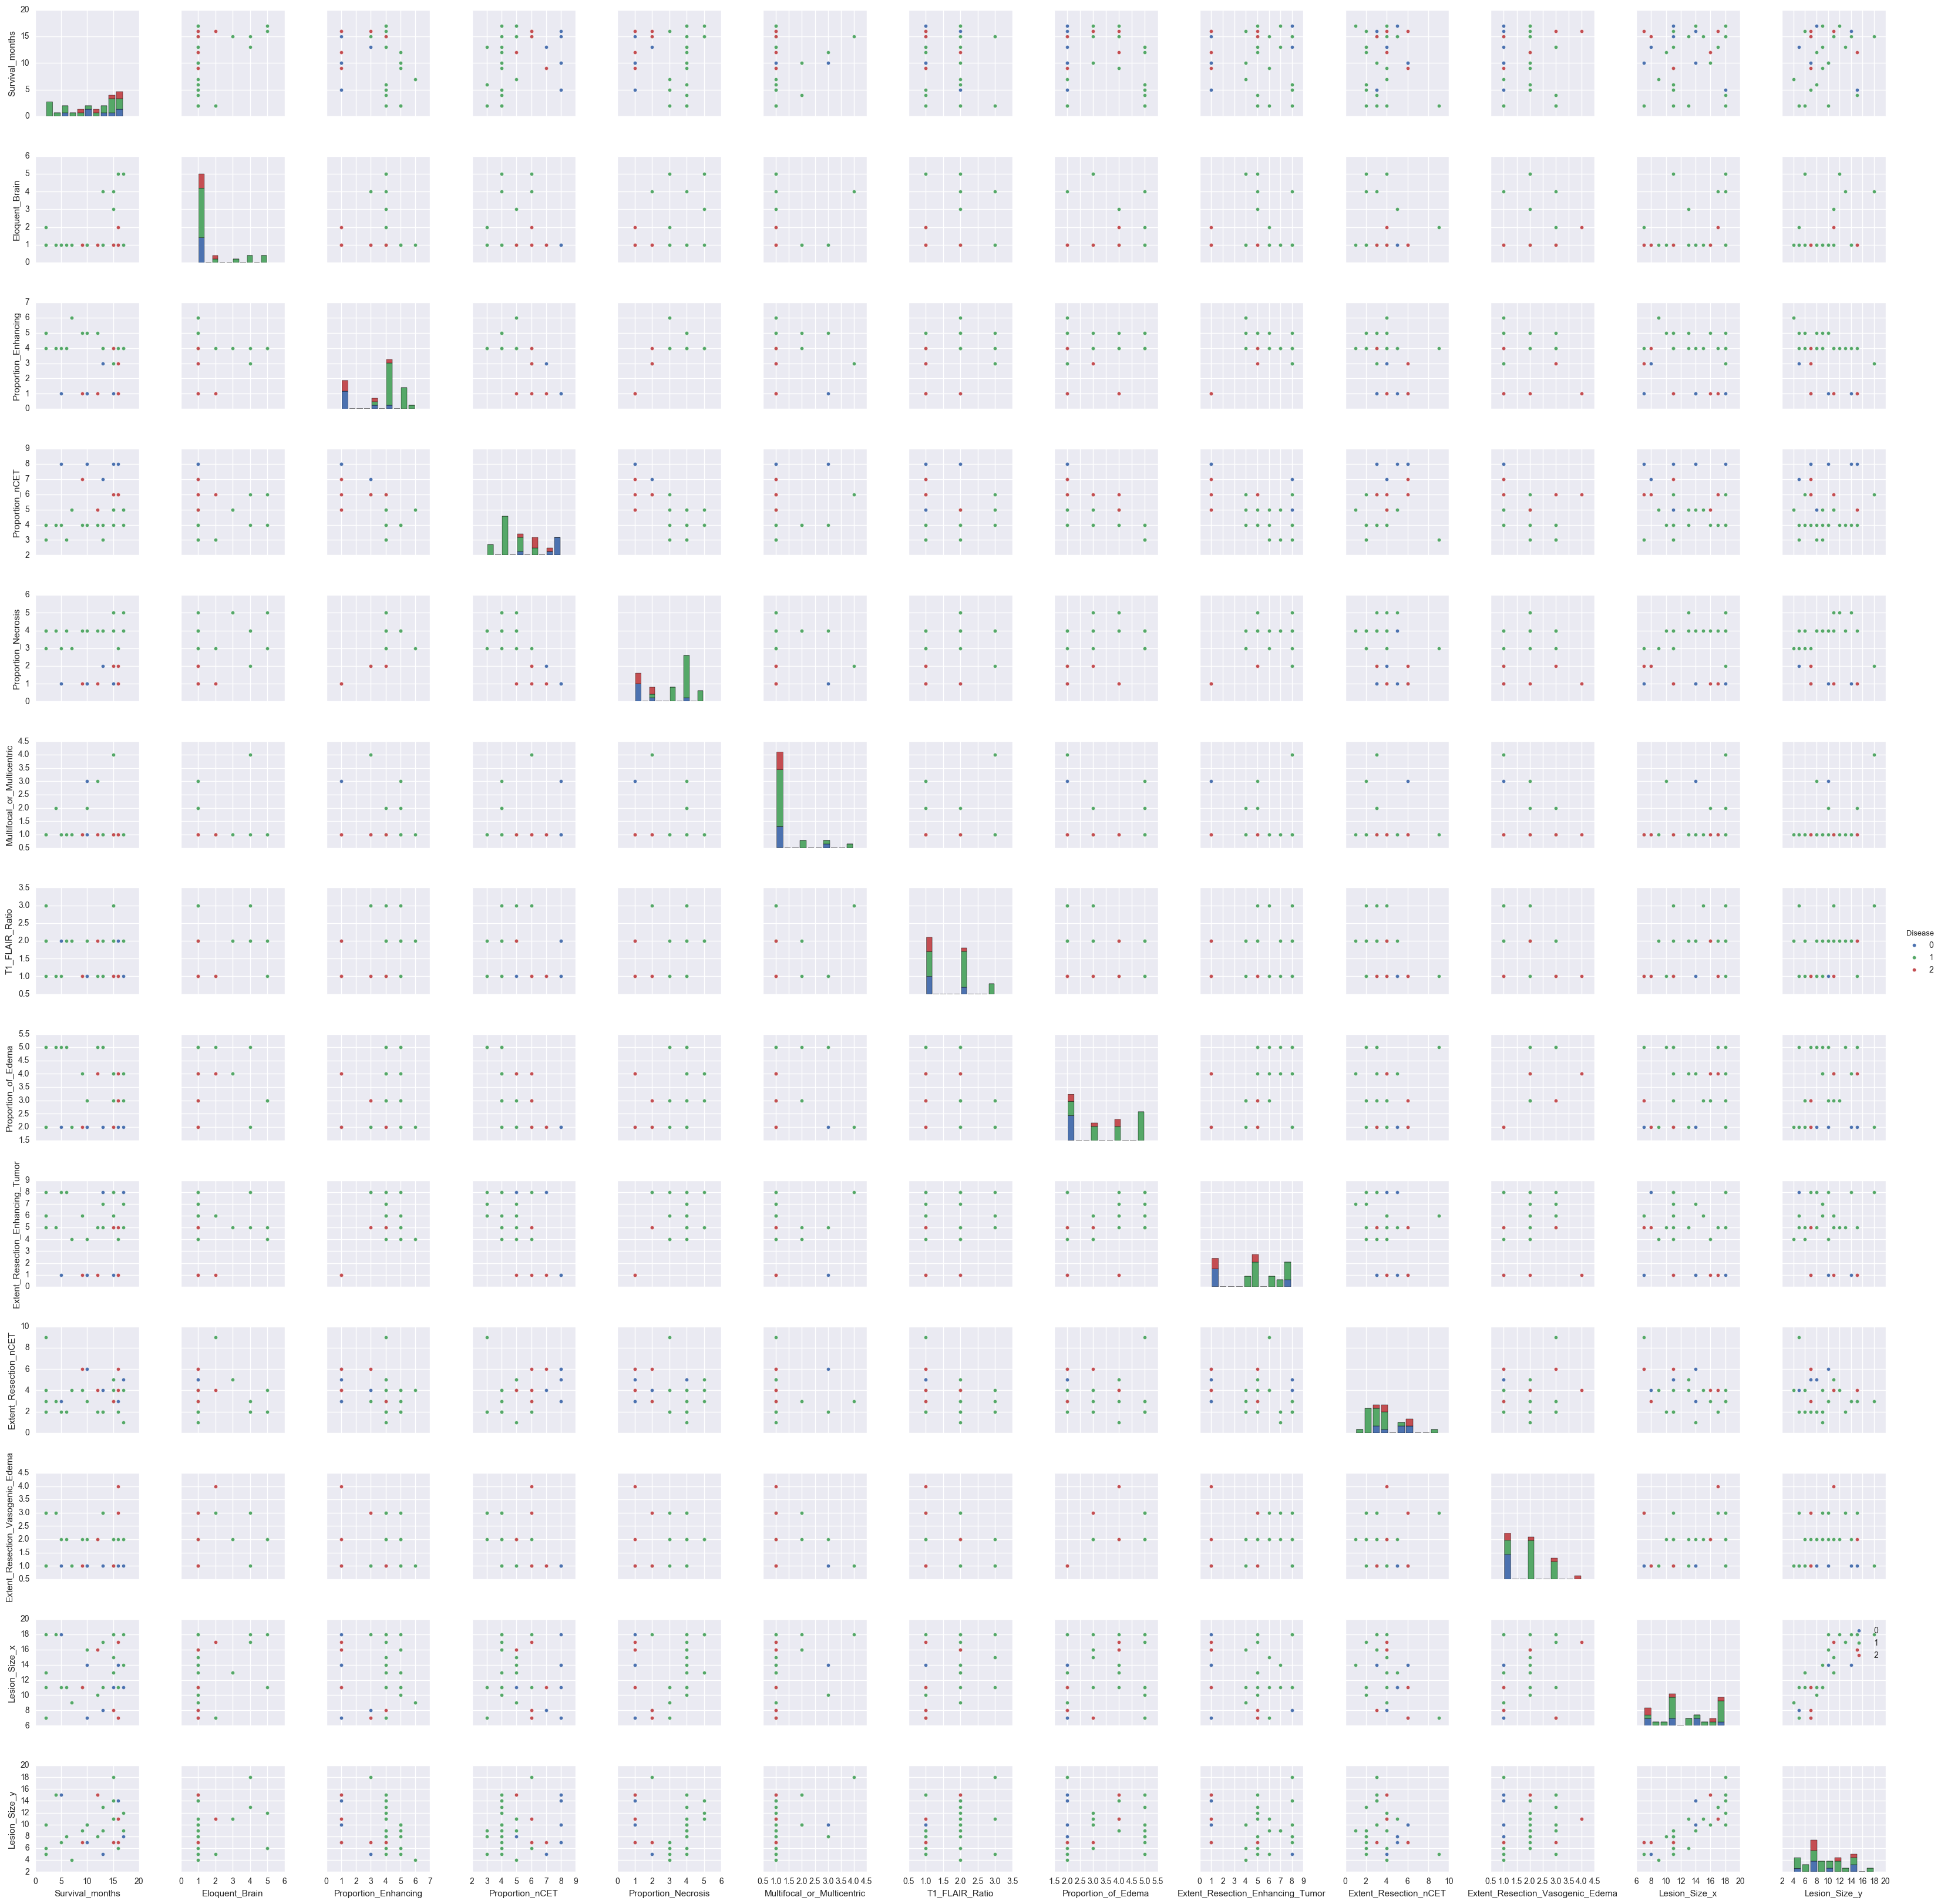

In [14]:
# Plot relations between variables and display tumour types

sns.pairplot(tumours, hue='Disease', hue_order=[0,1,2], vars=['Survival_months',
                                            'Eloquent_Brain','Proportion_Enhancing','Proportion_nCET',
                                            'Proportion_Necrosis','Multifocal_or_Multicentric','T1_FLAIR_Ratio',
                                            'Proportion_of_Edema','Extent_Resection_Enhancing_Tumor',
                                            'Extent_Resection_nCET','Extent_Resection_Vasogenic_Edema',
                                            'Lesion_Size_x', 'Lesion_Size_y'])
plt.legend()
plt.show()

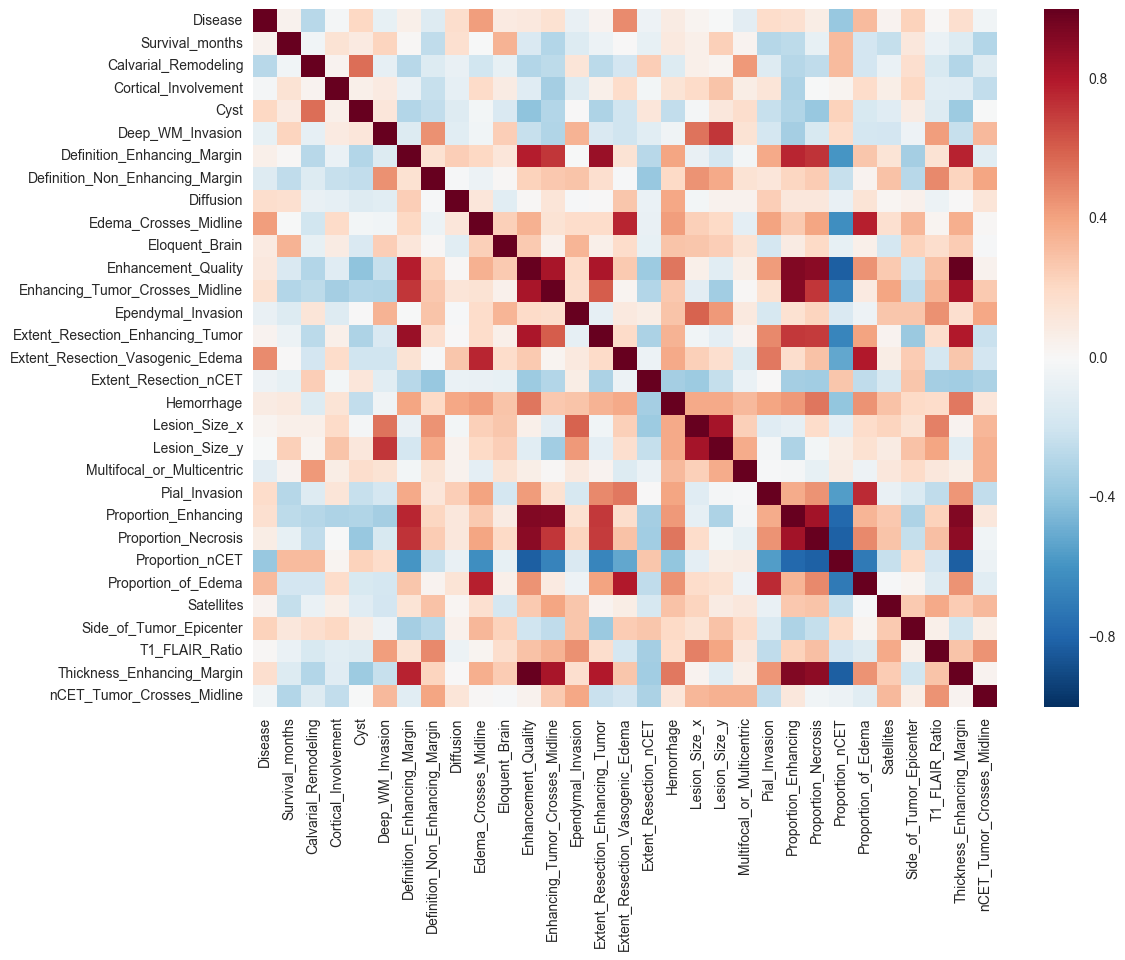

In [15]:
#Plot correlation heatmap

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(tumours.corr())

Based on this first exploratory analysis, the tumor type ('Disease') doesn't seem to be particularly correlated to any specific features (there seems to be a slight correlation to edema features and nCET).  
Some features such as Lesion_size_x and Lesion_size_y or Proportions of enhancing tissue, necrosis and nCET seem to be strongly correlated. Therefore we will apply some techniques such as Lasso, PCA and LDA to try and reduce the influence of correlated features.

<a id='Part4'></a>

## 4. Studying feature importance with PCA

In [5]:
from sklearn.preprocessing import MinMaxScaler

X = tumours.drop(['Sample', 'Disease', 'Survival_months', 'Tumor_Location'], axis=1)
X_cols = X.columns
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)
X.head()

,Calvarial_Remodeling,Cortical_Involvement,Cyst,Deep_WM_Invasion,Definition_Enhancing_Margin,Definition_Non_Enhancing_Margin,Diffusion,Edema_Crosses_Midline,Eloquent_Brain,Enhancement_Quality,Enhancing_Tumor_Crosses_Midline,Ependymal_Invasion,Extent_Resection_Enhancing_Tumor,Extent_Resection_Vasogenic_Edema,Extent_Resection_nCET,Hemorrhage,Lesion_Size_x,Lesion_Size_y,Multifocal_or_Multicentric,Pial_Invasion,Proportion_Enhancing,Proportion_Necrosis,Proportion_nCET,Proportion_of_Edema,Satellites,Side_of_Tumor_Epicenter,T1_FLAIR_Ratio,Thickness_Enhancing_Margin,nCET_Tumor_Crosses_Midline
0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500,0.0,0.363636,0.214286,0.0,0.0,0.0,0.00,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.5,0.0,1.000000,0.5,0.5,1.0,0.5,1.0,0.571429,0.333333,0.500,1.0,0.545455,0.500000,0.0,1.0,0.6,1.00,0.4,0.666667,0.0,1.0,0.5,1.0,0.0
2,0.0,1.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,1.0,0.5,1.0,1.000000,0.000000,0.500,0.0,0.363636,0.285714,0.0,0.0,0.6,0.75,0.4,0.000000,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.5,0.0,0.000000,0.5,0.0,1.0,0.5,0.0,0.857143,0.333333,0.000,0.0,0.636364,0.357143,0.0,0.0,0.6,0.75,0.4,0.666667,0.0,1.0,0.5,1.0,0.0
4,0.0,1.0,0.0,1.0,0.5,1.0,0.000000,0.5,1.0,1.0,0.5,1.0,0.571429,0.333333,0.375,0.0,1.000000,0.571429,0.0,0.0,0.6,1.00,0.2,0.333333,0.0,0.0,0.5,1.0,0.0


In [41]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

pd.DataFrame(np.cumsum([round(i*100, 2) for i in pca.explained_variance_ratio_]), index=range(1,30), columns=['Cumulative % of Variance Explained']).head(10)

,Cumulative % of Variance Explained
1,30.74
2,47.93
3,59.78
4,67.76
5,73.62
6,78.13
7,81.67
8,84.97
9,87.79
10,90.27


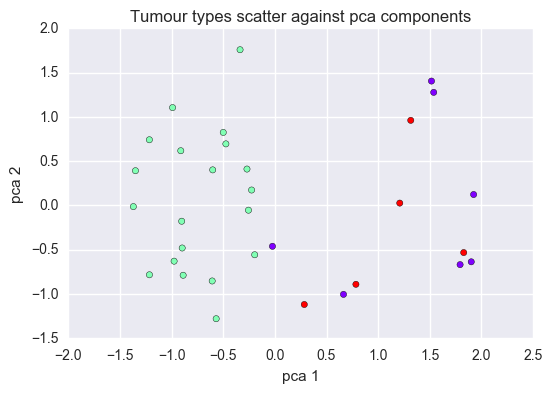

In [42]:
X_pca = PCA(n_components=2).fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=tumours['Disease'], cmap='rainbow')
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.title('Tumour types scatter against pca components')
plt.show()

The first two PCA components only account for 48% of the variance explained and we can see that with these two components only it would be difficult to distinguish between atrocytomas and oligodendrogliomas (pca1 > 0). Moreover in our case, PCA doesn't allows us to extract less features from the original images so we will not be using it in any further analysis.

<a id='Part5'></a>

## 5. Building and training models on manually extracted features

In [6]:
y = tumours['Disease']

In [7]:
print 'Baseline accuracy:', y.value_counts()[1]/float(len(y))

Baseline accuracy: 0.625


In [76]:
# Store all model scores in a list of tuples to compare them
model_scores = []

<a id='Part5a'></a>

### a. Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

logreg = LogisticRegression()

print 'Cross validated accuracy scores logistic regression C=1, Ridge penalty:', cross_val_score(logreg, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(logreg, X, y, cv=3).mean()

Cross validated accuracy scores logistic regression C=1, Ridge penalty: [ 0.83333333  0.63636364  0.77777778]
Mean cross validated accuracy: 0.749158249158


Optimise model with GridSearchCV

In [78]:
gs_logreg = GridSearchCV(logreg, {'C': [10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 0.1, 1], 'penalty':['l1','l2']})
gs_logreg.fit(X,y)

print 'Regression parameters:', gs_logreg.best_params_, '\n'

print 'Cross validated accuracy logistic regression C=0.1, Ridge penalty (optimised):', gs_logreg.best_score_

model_scores.append(('gs_logreg', gs_logreg.best_score_))

Regression parameters: {'penalty': 'l1', 'C': 1} 

Cross validated accuracy logistic regression C=0.1, Ridge penalty (optimised): 0.75


In [79]:
from sklearn.metrics import classification_report, confusion_matrix

print confusion_matrix(y, cross_val_predict(gs_logreg.best_estimator_, X, y, cv=3))
print classification_report(y, cross_val_predict(gs_logreg.best_estimator_, X, y, cv=3))

[[ 4  2  1]
 [ 0 20  0]
 [ 3  2  0]]
             precision    recall  f1-score   support

          0       0.57      0.57      0.57         7
          1       0.83      1.00      0.91        20
          2       0.00      0.00      0.00         5

avg / total       0.65      0.75      0.69        32



<a id='Part5b'></a>

### b. KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

print 'Cross validated accuracy scores KNN 5 neighbours:', cross_val_score(knn, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(knn, X, y, cv=3).mean()

Cross validated accuracy scores KNN 5 neighbours: [ 0.83333333  0.72727273  0.66666667]
Mean cross validated accuracy: 0.742424242424


Optimise model with GridSearchCV

In [81]:
gs_knn = GridSearchCV(knn, {'n_neighbors': range(1, 11)})
gs_knn.fit(X,y)

print 'KNN parameters:', gs_knn.best_params_, '\n'

print 'Cross validated accuracy KNN 7 neighbours:', gs_knn.best_score_

model_scores.append(('gs_knn', gs_knn.best_score_))

KNN parameters: {'n_neighbors': 6} 

Cross validated accuracy KNN 7 neighbours: 0.8125


<a id='Part5c'></a>

### c. Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

print 'Cross validated accuracy scores random forest:', cross_val_score(rfc, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfc, X, y, cv=3).mean()

Cross validated accuracy scores random forest: [ 0.83333333  0.81818182  0.88888889]
Mean cross validated accuracy: 0.807239057239


Optimise model with GridSearchCV

In [83]:
gs_rfc = GridSearchCV(rfc, {'n_estimators': range(5, 85, 5)})
gs_rfc.fit(X,y)

print 'Random forest parameters:', gs_rfc.best_params_, '\n'

print 'Cross validated accuracy Random Forest 30 estimators:', gs_rfc.best_score_

model_scores.append(('gs_rfc', gs_rfc.best_score_))

Random forest parameters: {'n_estimators': 25} 

Cross validated accuracy Random Forest 30 estimators: 0.875


In [84]:
print confusion_matrix(y, cross_val_predict(gs_rfc.best_estimator_, X, y, cv=3))
print classification_report(y, cross_val_predict(gs_rfc.best_estimator_, X, y, cv=3))

[[ 5  1  1]
 [ 1 19  0]
 [ 2  0  3]]
             precision    recall  f1-score   support

          0       0.71      0.71      0.71         7
          1       0.91      1.00      0.95        20
          2       0.67      0.40      0.50         5

avg / total       0.83      0.84      0.83        32



The optimised random forest model seems to be performing very well, in particular it classifies all the GBMs acurately.

<a id='Part5d'></a>

### d. LDA

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

X_lda = lda.fit_transform(X, y)
lda.explained_variance_ratio_

array([ 0.97163295,  0.02836705])

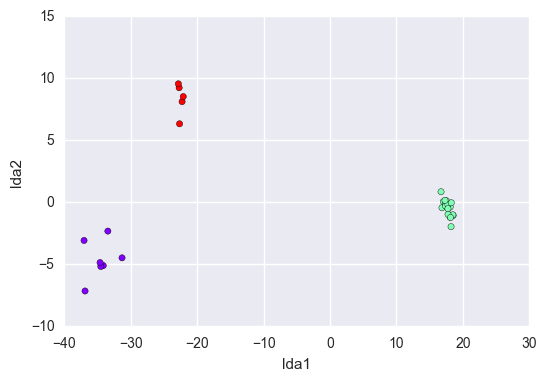

In [86]:
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='rainbow')
plt.xlabel('lda1')
plt.ylabel('lda2')
plt.show()

In [87]:
print 'Cross validated accuracy scores LDA:', cross_val_score(lda, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(lda, X, y, cv=3).mean()

model_scores.append(('LDA',cross_val_score(lda, X, y, cv=3).mean()))

Cross validated accuracy scores LDA: [ 0.83333333  0.72727273  0.22222222]
Mean cross validated accuracy: 0.594276094276


In [88]:
print confusion_matrix(y, cross_val_predict(lda, X, y, cv=3))
print classification_report(y, cross_val_predict(lda, X, y, cv=3))

[[ 4  1  2]
 [ 4 13  3]
 [ 1  1  3]]
             precision    recall  f1-score   support

          0       0.44      0.57      0.50         7
          1       0.87      0.65      0.74        20
          2       0.38      0.60      0.46         5

avg / total       0.70      0.62      0.65        32



LDA components seem to give a very accurate sepration of the three classes - with the first component explaining over 97% of the variance. However cross-validated predictions are quite unstable and can give poor results. It would be interesting to check this method against a bigger dataset once I extract the features from the rest of the dataset.

<a id='Part5e'></a>

### e. Naive Bayes

In [89]:
from sklearn.naive_bayes import MultinomialNB

nbm = MultinomialNB()

print 'Cross validated accuracy scores Naive Bayes:', cross_val_score(nbm, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(nbm, X, y, cv=3).mean()

model_scores.append(('NBm', cross_val_score(nbm, X, y, cv=3).mean()))

Cross validated accuracy scores Naive Bayes: [ 0.75        0.72727273  0.77777778]
Mean cross validated accuracy: 0.751683501684


In [90]:
print confusion_matrix(y, cross_val_predict(nbm, X, y, cv=3))
print classification_report(y, cross_val_predict(nbm, X, y, cv=3))

[[ 4  2  1]
 [ 1 19  0]
 [ 2  2  1]]
             precision    recall  f1-score   support

          0       0.57      0.57      0.57         7
          1       0.83      0.95      0.88        20
          2       0.50      0.20      0.29         5

avg / total       0.72      0.75      0.72        32



<a id='Part5f'></a>

### f. Compare model scores

In [91]:
print 'Model scores', model_scores

Model scores [('gs_logreg', 0.75), ('gs_knn', 0.8125), ('gs_rfc', 0.875), ('LDA', 0.59427609427609429), ('NBm', 0.75168350168350173)]


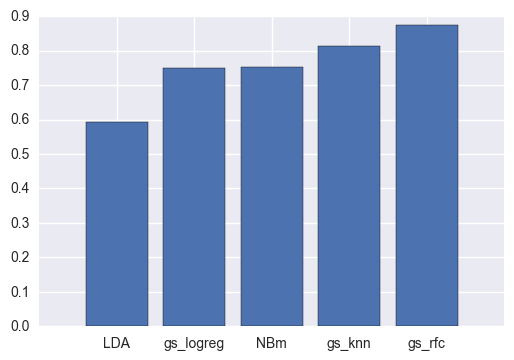

In [92]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(5), [tup[1] for tup in model_scores], align='center')
plt.xticks(range(5), [tup[0] for tup in model_scores])
plt.show()

<a id='Part6'></a>

## 6. Feature Selection

<a id='Part6a'></a>

### a. SelectKBest

In [93]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=5)
selected_data = selector.fit_transform(X, y)
kbest_columns = X.columns[selector.get_support()]
Xtbest = pd.DataFrame(selected_data, columns=kbest_columns)
Xtbest.head()

,Enhancement_Quality,Proportion_Enhancing,Proportion_Necrosis,Proportion_nCET,Thickness_Enhancing_Margin
0,0.0,0.0,0.00,1.0,0.0
1,1.0,0.6,1.00,0.4,1.0
2,1.0,0.6,0.75,0.4,1.0
3,1.0,0.6,0.75,0.4,1.0
4,1.0,0.6,1.00,0.2,1.0


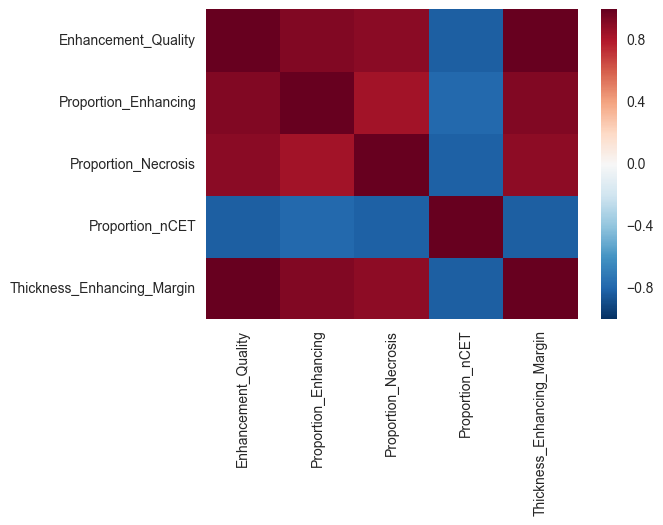

In [94]:
sns.heatmap(tumours[kbest_columns].corr())

In [95]:
pd.DataFrame({'columns':X.columns, 'p_values':selector.pvalues_}).sort_values('p_values').head(10)

,columns,p_values
9,Enhancement_Quality,1.222770e-10
27,Thickness_Enhancing_Margin,7.099996e-10
22,Proportion_nCET,2.079979e-08
21,Proportion_Necrosis,6.455087e-08
20,Proportion_Enhancing,2.704213e-07
10,Enhancing_Tumor_Crosses_Midline,5.254509e-05
12,Extent_Resection_Enhancing_Tumor,1.535407e-03
15,Hemorrhage,1.547425e-03
23,Proportion_of_Edema,1.682849e-03
4,Definition_Enhancing_Margin,2.458544e-03


#### Logistic Regression

In [96]:
print 'Cross validated accuracy scores logistic regression on KBest columns:', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3).mean()

model_scores.append(('Logreg_kbest', cross_val_score(gs_logreg.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores logistic regression on KBest columns: [ 0.75        0.72727273  0.88888889]
Mean cross validated accuracy: 0.788720538721


#### KNN

In [97]:
print 'Cross validated accuracy scores knn on KBest columns:', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3).mean()

model_scores.append(('KNN_kbest', cross_val_score(gs_knn.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores knn on KBest columns: [ 0.75        0.81818182  0.88888889]
Mean cross validated accuracy: 0.819023569024


#### Random Forests on KBest columns

In [98]:
print 'Cross validated accuracy scores random forest on KBest columns:', cross_val_score(rfc, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfc, Xtbest, y, cv=3).mean()

model_scores.append(('rfc_kbest', cross_val_score(gs_rfc.best_estimator_, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores random forest on KBest columns: [ 0.91666667  0.90909091  0.88888889]
Mean cross validated accuracy: 0.904882154882


#### Naive Bayes on KBest columns

In [99]:
print 'Cross validated accuracy scores random forest on KBest columns:', cross_val_score(nbm, Xtbest, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(nbm, Xtbest, y, cv=3).mean()

model_scores.append(('nbm_kbest', cross_val_score(nbm, Xtbest, y, cv=3).mean()))

Cross validated accuracy scores random forest on KBest columns: [ 0.75        0.72727273  0.88888889]
Mean cross validated accuracy: 0.788720538721


#### Compare model scores

In [100]:
print 'Model scores:', model_scores

Model scores: [('LDA', 0.59427609427609429), ('gs_logreg', 0.75), ('NBm', 0.75168350168350173), ('gs_knn', 0.8125), ('gs_rfc', 0.875), ('Logreg_kbest', 0.7887205387205386), ('KNN_kbest', 0.8190235690235691), ('rfc_kbest', 0.90488215488215484), ('nbm_kbest', 0.7887205387205386)]


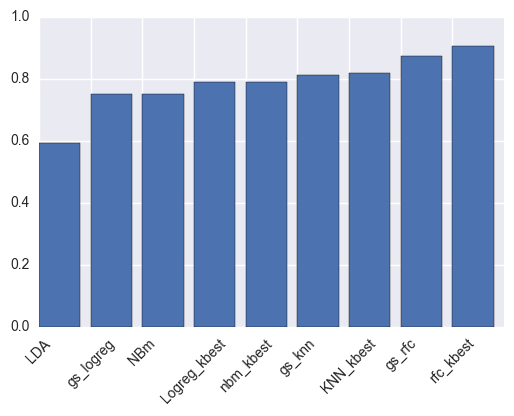

In [101]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(9), [tup[1] for tup in model_scores])
plt.xticks(range(9), [tup[0] for tup in model_scores], rotation=45)
plt.show()

Selecting only the 5 best columns improved the accuracy of the Random Forest model. However since these 5 columns are correlated the random forest might be overfitting.

<a id='Part6b'></a>

### b. RFE

#### Logistic Regression

In [102]:
from sklearn.feature_selection import RFE

rfe_logreg = RFE(gs_logreg.best_estimator_, n_features_to_select=5)
X_rfe_logreg = rfe_logreg.fit_transform(X, y)

In [103]:
rfe_logreg_columns = X.columns[rfe_logreg.get_support()]
X_rfe_logreg = pd.DataFrame(X_rfe_logreg, columns=rfe_logreg_columns)
X_rfe_logreg.head()

,Enhancement_Quality,Hemorrhage,Proportion_nCET,Proportion_of_Edema,Thickness_Enhancing_Margin
0,0.0,0.0,1.0,0.000000,0.0
1,1.0,1.0,0.4,0.666667,1.0
2,1.0,0.0,0.4,0.000000,1.0
3,1.0,0.0,0.4,0.666667,1.0
4,1.0,0.0,0.2,0.333333,1.0


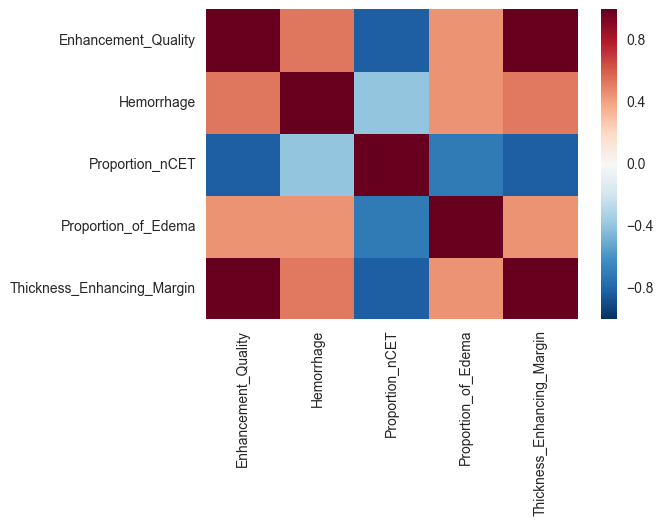

In [104]:
sns.heatmap(tumours[rfe_logreg_columns].corr())

In [105]:
print 'Cross validated accuracy scores RFE logistic regression:', cross_val_score(rfe_logreg, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfe_logreg, X, y, cv=3).mean()

model_scores.append(('logreg_rfe', cross_val_score(rfe_logreg, X, y, cv=3).mean()))

Cross validated accuracy scores RFE logistic regression: [ 0.75        0.72727273  0.88888889]
Mean cross validated accuracy: 0.788720538721


#### Random Forest

In [106]:
rfe_rf = RFE(rfc, n_features_to_select=5)
X_rfe_rf = rfe_rf.fit_transform(X, y)
rfe_rf_columns = X.columns[rfe_rf.get_support()]
X_rfe_rf = pd.DataFrame(X_rfe_rf, columns=rfe_rf_columns)
X_rfe_rf.head()

,Extent_Resection_Vasogenic_Edema,Extent_Resection_nCET,Proportion_Enhancing,Proportion_nCET,Thickness_Enhancing_Margin
0,0.000000,0.500,0.0,1.0,0.0
1,0.333333,0.500,0.6,0.4,1.0
2,0.000000,0.500,0.6,0.4,1.0
3,0.333333,0.000,0.6,0.4,1.0
4,0.333333,0.375,0.6,0.2,1.0


In [107]:
print 'RFE logistic regression columns:', rfe_logreg_columns.values
print 'RFE random forest columns:', rfe_rf_columns.values

RFE logistic regression columns: [u'Enhancement_Quality' u'Hemorrhage' u'Proportion_nCET'
 u'Proportion_of_Edema' u'Thickness_Enhancing_Margin']
RFE random forest columns: [u'Extent_Resection_Vasogenic_Edema' u'Extent_Resection_nCET'
 u'Proportion_Enhancing' u'Proportion_nCET' u'Thickness_Enhancing_Margin']


In [108]:
print 'Cross validated accuracy scores RFE logistic regression:', cross_val_score(rfe_rf, X, y, cv=3)
print 'Mean cross validated accuracy:', cross_val_score(rfe_rf, X, y, cv=3).mean()

model_scores.append(('rfc_rfe', cross_val_score(rfe_rf, X, y, cv=3).mean()))

Cross validated accuracy scores RFE logistic regression: [ 0.91666667  0.90909091  0.55555556]
Mean cross validated accuracy: 0.73569023569


<a id='Part6c'></a>

### c. Compare model scores

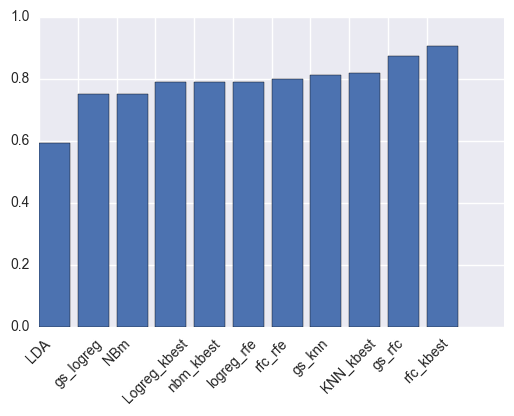

In [110]:
model_scores.sort(key=lambda tup: tup[1])

plt.bar(range(11), [tup[1] for tup in model_scores])
plt.xticks(range(11), [tup[0] for tup in model_scores], rotation=45)
plt.show()

The features selected by the RFE model applied on logistic regression and the one applied on random forest are very similar. They are also very similar to the SelectKBest features. However RFE features perform worse than SelectKBest features.

Random forest on SelectKBest features gives the best cross-validated accuracy.

## ----

<a id='Part7'></a>

## 7. Extraction of MRI scans 
(please see separate notebook for the whole workflow - the below is only a summary of the best working technique I found so far)

In [10]:
import SimpleITK

In [11]:
# int labels to assign to the segmented tumour
labelWhiteMatter = 1
labelTumour = 2

In [12]:
# Define a function to display one ITK image

def sitk_show(img, title=None, margin=0.0, dpi=40, axis='off'):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    ax.axis(axis)
    
    if title:
        plt.title(title)
    
    plt.show()

In [13]:
# Define a function to display the 4 sequences

sequence_names = ['T1', 'T2', 'FLAIR', 'T1 GD']

def sitk_show_4seq(imgs, margin=0.05, dpi=40, axis='off', size=(5,5)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=size)
        
    for ax, img, seq in zip([ax1,ax2,ax3,ax4], imgs, sequence_names):
        nda = SimpleITK.GetArrayFromImage(img)
        spacing = img.GetSpacing()
        figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
        extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

        plt.set_cmap("gray")
        ax.imshow(nda,extent=extent,interpolation=None)
        ax.set_title(seq)
        ax.axis(axis)
    
    fig.show()

In [14]:
# Load in DICOM images for 1 patient

# Load in the 4 main sequences: T1, T2, FLAIR and post-IV (= T1 GD)
PathDicom_T1 = "./REMBRANDT/900-00-1961/AX_T1/"
PathDicom_T2 = "./REMBRANDT/900-00-1961/AX_T2/"
PathDicom_FLAIR = "./REMBRANDT/900-00-1961/AX_FLAIR/"
PathDicom_T1GD = "./REMBRANDT/900-00-1961/AX_T1_GD/"

# Load in image series
def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

img_T1_Original = import_img_series(PathDicom_T1)
img_T2_Original = import_img_series(PathDicom_T2)
img_FLAIR_Original = import_img_series(PathDicom_FLAIR)
img_T1GD_Original = import_img_series(PathDicom_T1GD)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

<a id='Part7a'></a>

### a. Reshape images

In [35]:
# Resize T2 and T1GD images to 256x256 pixels
shrinker = SimpleITK.ShrinkImageFilter()
shrinker.SetShrinkFactors([2,2,1])
img_T2_Original = shrinker.Execute(img_T2_Original)
img_T1GD_Original = shrinker.Execute(img_T1GD_Original)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

for seq, img in zip(sequence_names, img_4seq):
    print seq,':', img.GetSize()

T1 : (256, 256, 20)
T2 : (256, 256, 20)
FLAIR : (256, 256, 20)
T1 GD : (256, 256, 60)


In [37]:
# Redefine images origins and spacings to be able to compose a mix of these 4 images
for i in img_4seq:
    i.SetOrigin((-105.0097885131836, -92.68102264404297, -69.89035034179688))
    i.SetSpacing((0.859375, 0.859375, 7.5))

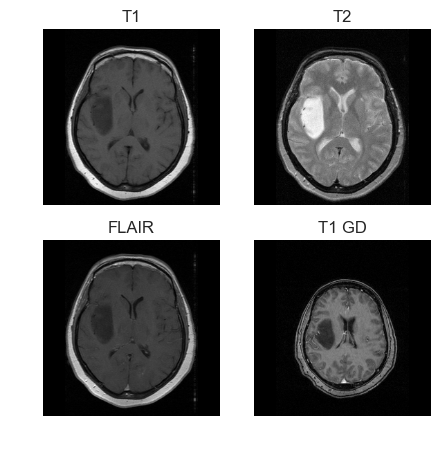

In [111]:
# Define list of images of slice 10 in 4 sequences (2D images)
img_4seq_slice10 = [img_T1_Original[:,:,10], img_T2_Original[:,:,10], 
                    img_FLAIR_Original[:,:,10], img_T1GD_Original[:,:,32]]

sitk_show_4seq(img_4seq_slice10)

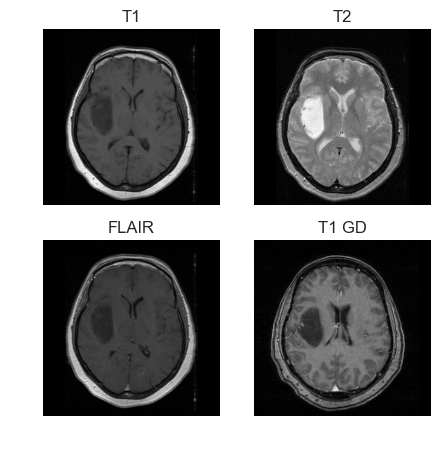

In [112]:
# Crop T1 GD image so it centered similarly to the other sequences - However size is therefore reduced!
crop_up = SimpleITK.CropImageFilter()
crop_up.SetUpperBoundaryCropSize((20,20))
crop_up.SetLowerBoundaryCropSize((40,40))
img_4seq_slice10[3] = crop_up.Execute(img_4seq_slice10[3])
sitk_show_4seq(img_4seq_slice10)

In [113]:
img_4seq_slice10[3].GetSize()

(196, 196)

<a id='Part7b'></a>

### b. Remove noise

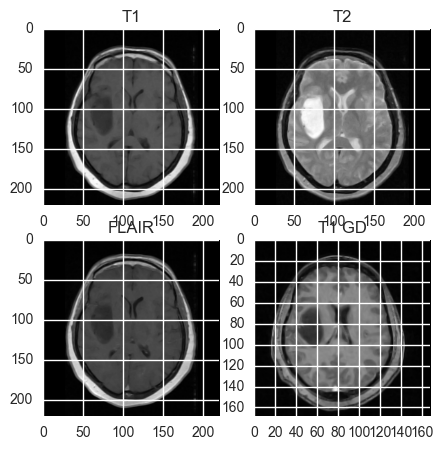

In [73]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_4seq_slice10 = []

for img in img_4seq_slice10:
    imgSmooth_4seq_slice10.append(SimpleITK.CurvatureFlow(image1=img,
                                    timeStep=0.125,
                                    numberOfIterations=5))

sitk_show_4seq(imgSmooth_4seq_slice10, axis='on', size=(5,5))

<a id='Part7c'></a>

### c. Multimodal segmentation from T2 and FLAIR images

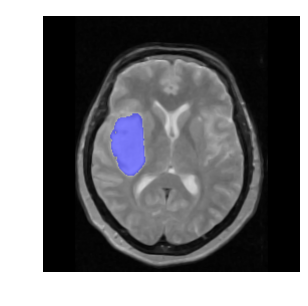

In [70]:
lstSeeds = [(80, 120), (70, 130), (75, 105), (75,140)]

# Merge T2 and FLAIR images
imgComp = SimpleITK.Compose(imgSmooth_4seq_slice10[1], imgSmooth_4seq_slice10[2])

# Compute tumour volume based on newly composed image
imgTumourComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=3,
                                               multiplier=4.7,
                                               replaceValue=labelTumour)
imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[1]), 
                                           imgTumourComp.GetPixelID())

# Display resulting segmentation on top of composed image
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumourComp), dpi=100)

<a id='Part7d'></a>

### d. Extract features

In [74]:
# Get tumour dimensions with this new segmentation

label_shape_analysis_comp = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_comp.SetBackgroundValue(0)
label_shape_analysis_comp.Execute(imgTumourComp)

print 'T2 and FLAIR composed image Confidence Connected dimensions'
print 'Centre location:', imgTumourComp.TransformPhysicalPointToIndex(label_shape_analysis_comp.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_comp.GetNumberOfPixels(labelTumour)

T2 and FLAIR composed image Confidence Connected dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (28.811608007863505, 53.132769385781444)
Number of pixels in tumour: 1628


In [92]:
# Define fonction to convert tumour diameters to originally encoded labels from 1 to 18
def size_label(x):
    j = round(x,1)
    if j<5:
        return 1
    elif j<=7.5:
        return 2
    elif j<=12.5:
        return 3
    elif j<=17.5:
        return 4
    elif j<=22.5:
        return 5
    elif j<=27.5:
        return 6
    elif j<=32.5:
        return 7
    elif j<=37.5:
        return 8
    elif j<=42.5:
        return 9
    elif j<=47.5:
        return 10
    elif j<=52.5:
        return 11
    elif j<=57.5:
        return 12
    elif j<=62.5:
        return 13
    elif j<=67.5:
        return 14
    elif j<=72.5:
        return 15
    elif j<=77.5:
        return 16
    elif j<=80:
        return 17
    else:
        return 18

# Define function to return largest encoded diametre first
def convert_size_to_label((x,y)):
    a=0
    b=0
    # Largest returned diameter first 
    if x>y:
        a=x
        b=y
    else:
        a=y
        b=x
    # Assign labels to each diameter
    return (size_label(a),size_label(b))

In [86]:
# Define fonction to convert tumour centre location to originally encoded label: 3 if left, 1 if right, 2 if centre
# This refers to the side of the brain so it will appear on the opposite side on the image (mirror effect)
# /!\ HOW TO CHECK IF BILATERAL??

def convert_centre_location_to_side_label((x,y)):
    if int(x)>128:
        return 3
    elif int(x)<128:
        return 1
    else:
        return 2

In [94]:
# Compare with manually calculated dimensions (stored in tumours dataframe)

print 'Automatically computed features'
print 'X dimension:', convert_size_to_label(label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour))[0]
print 'Y dimension:', convert_size_to_label(label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour))[1]
print 'Side of tumour epicentre:', convert_centre_location_to_side_label(imgTumourComp.TransformPhysicalPointToIndex(label_shape_analysis_comp.GetCentroid(labelTumour)))

print '-------'

print 'Manually extracted features (from tumours dataframe)'
print 'X dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_x'].values[0]
print 'Y dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_y'].values[0]
print 'Side of tumour epicentre:', tumours.loc[tumours['Sample']=='900_00_1961', 'Side_of_Tumor_Epicenter'].values[0]

Automatically computed features
X dimension: 12
Y dimension: 7
Side of tumour epicentre: 1
-------
Manually extracted features (from tumours dataframe)
X dimension: 11
Y dimension: 7
Side of tumour epicentre: 1
